<a href="https://colab.research.google.com/github/iliailmer/harmonic_network/blob/master/skin_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#!pip3 install fastai==0.7.0
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
#!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0.post4-{platform}-linux_x86_64.whl torchvision
!pip install -q torch==1.0.0 torchvision
!pip install torch-dct

import torch

!pip install Pillow==4.0.0
!pip install image
!pip install torchtext==0.2.3

!pip install kaggle

from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

#!ln -s ~/.local/bin/kaggle /usr/bin/kaggle
print(f"CUDA is available: {torch.cuda.is_available()}")
torch.cuda.set_device(0)

from google.colab import drive
drive.mount('/content/drive')

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp drive/My\ Drive/kaggle.json ~/.kaggle/
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
!unzip skin-cancer-mnist-ham10000.zip

100% 2.61G/2.62G [00:38<00:00, 87.2MB/s]
100% 2.62G/2.62G [00:38<00:00, 72.4MB/s]
Archive:  skin-cancer-mnist-ham10000.zip
  inflating: hmnist_28_28_RGB.csv    
  inflating: HAM10000_metadata.csv   
  inflating: HAM10000_images_part_1.zip  
  inflating: hmnist_28_28_L.csv      
  inflating: hmnist_8_8_L.csv        
  inflating: HAM10000_images_part_2.zip  
  inflating: hmnist_8_8_RGB.csv      


In [0]:
%%capture
!mkdir HAM10000_images
!unzip HAM10000_images_part_1.zip -d HAM10000_images
!unzip HAM10000_images_part_2.zip -d HAM10000_images
!rm HAM10000_images_part_1.zip HAM10000_images_part_2.zip skin-cancer-mnist-ham10000.zip


In [0]:
import pandas as pd
import numpy as np
from scipy import fftpack
from matplotlib import pyplot as plt
import seaborn as sns
import statistics
import albumentations as alb
import os

from skimage import color, io, morphology, feature, segmentation, exposure
from glob import glob
import typing

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from skimage.exposure import rescale_intensity

In [7]:
import gc
gc.collect()

0

In [0]:
def rescale(image, mn=0, mx=1):
  return rescale_intensity(image,out_range=(mn,mx))

def EME(image, window_height=11, window_width=11):
    """
    EME measure for showing image quality based on human visual system.
    For details, see
    Agaian, Sos S., Karen Panetta,
    and Artyom M. Grigoryan.
    "A new measure of image enhancement."
    IASTED International Conference on Signal Processing & Communication.
    Citeseer, 2000.

    :param image: input image, must be single-channel.
    :param window_height: height of the inspecting window
    :param window_width: width of the inspecting window
    :return: A real-valued enhancement measure.
    """
    height, width = image.shape
    # k_1 = np.floor(height/window_height)
    # k_2 = np.floor(width/window_width)
    sum_ = 0
    k = 0
    H = np.int(np.floor(window_height / 2))  # range in height, distance from the center of the window
    W = np.int(np.floor(window_width / 2))  # range in width, same as above
    for row in range(0 + H, height - H + 1, window_height):
        for column in range(0 + W, width - W + 1, window_width):

            window = image[row - H:row + H + 1, column - W:column + W + 1]

            I_max = window.max()
            I_min = window.min()

            D = (I_max + 1) / (I_min + 1)
            if D < 0.02:
                D = 0.02
            k += 1
            sum_ += 20 * np.log(D)
        # sum_k_1 += sum_k_2
        # sum_k_2 = 0

    eme = sum_ / k
    return eme


def EME_color(image):
    """
    Application of EME to color images.
    :param image: color image (multi-channel)
    :return: EME of that image
    """
    emes_ = []
    if image.shape[-1]>1:
        for each in range(image.shape[-1]):
            emes_.append(EME(image[:,:,each]))
    else:
        emes_.append(EME(image))
    return max(emes_)

def alpha_rooting_fourier(image: np.ndarray, alpha: float = 0.9) -> np.ndarray:
    ffted = fftpack.fft2(image)
    abs_ffted = np.absolute(ffted)**alpha
    iffted = fftpack.ifft2(abs_ffted*ffted/sp.absolute(ffted))
    iffted = rescale(np.absolute(iffted), 0, 1)#.astype(int)
    return iffted


In [0]:
!ls

adc.json	 HAM10000_metadata.csv	hmnist_8_8_L.csv
drive		 hmnist_28_28_L.csv	hmnist_8_8_RGB.csv
HAM10000_images  hmnist_28_28_RGB.csv	sample_data


In [0]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}



metadata = pd.read_csv('HAM10000_metadata.csv')
#imgs_28_rgb = pd.read_csv('hmnist_28_28_RGB.csv')

#labels = imgs_28_rgb['label'].values

#del imgs_28_rgb

#diag_by_txt = dict(zip(list(dict(metadata.dx.value_counts()).keys()),
#                       list(dict(pd.value_counts(labels)).keys())))
#diag_by_label = dict(zip(list(dict(pd.value_counts(labels)).keys()), 
#                         list(dict(metadata.dx.value_counts()).keys())))

#metadata['sex'] = pd.Categorical(metadata['sex']).codes
#metadata['label'] = metadata['dx'].map(diag_by_txt.get)
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('HAM10000_images', '*.jpg'))}
#metadata['path'] = metadata['image_id'].map(imageid_path_dict.get)
#metadata['image'] = metadata['path'].map(io.imread)
#metadata['diag_name'] = metadata['dx'].map(lesion_type_dict.get) 
#metadata.head()
#del metadata

In [5]:
from sklearn.preprocessing import  LabelEncoder

enc = LabelEncoder()
metadata['dx'] =enc.fit_transform(metadata['dx'])
metadata['dx_type'] =enc.fit_transform(metadata['dx_type'])
metadata['sex'] =enc.fit_transform(metadata['sex'])
metadata['localization'] =enc.fit_transform(metadata['localization'])
metadata['lesion_id'] =enc.fit_transform(metadata['lesion_id'])
metadata = metadata.sort_values(['image_id'], ascending=True).reset_index(drop=True)
labels = metadata.dx.values
metadata.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,550,ISIC_0024306,5,2,45.0,1,12
1,3542,ISIC_0024307,5,2,50.0,1,9
2,1471,ISIC_0024308,5,2,55.0,0,12
3,484,ISIC_0024309,5,2,40.0,1,12
4,3320,ISIC_0024310,4,3,60.0,1,3


In [6]:
gc.collect()

NameError: ignored

In [0]:
class Flatten(nn.Module):
  def __init__(self):
    super(Flatten, self).__init__()
    
  def forward(self, input):
    self.output_shape = input.view(input.size(0), -1).shape
    return input.view(input.size(0), -1)
      

from sklearn.model_selection import train_test_split
from skimage import io
from skimage.transform import resize
from skimage import color
import torchvision

class Loader(Dataset):
  def __init__(self,  path, labels, image_name = None,
               train=True, transform = None, color_space = 'rgb'):
    """
        Args:
            image_name (string): Name of the file in the image
            train (bool): whether to load training set or testing set
            path (string): Path to the folder with images.
            labels (np.ndarray): labels for images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
    """
    data = sorted(os.listdir(path))
    self.path = path
    self.train = train
    self.name = image_name
    self.transform = transform
    self.train_names, self.test_names, self.train_labels,  self.test_labels = train_test_split(np.asarray(data), 
                                                                                              np.asarray(labels),
                                                                                              test_size = 0.1)
    self.color_transform_dict = {'rgb':color.rgb2rgbcie, 'hed':color.rgb2hed, 'hsv':color.rgb2hsv, None:None}
    
    if self.train:
      if self.color_transform_dict[color_space] is not None:
        self.train_data = torch.from_numpy(np.asarray([rescale(np.transpose(resize(self.color_transform_dict[color_space](io.imread(os.path.join(self.path, name))),(224,224),mode = 'reflect').astype('float32'), (2,1,0))) for name in self.train_names]))
      else:
        self.train_data = torch.from_numpy(np.asarray([rescale(np.transpose(resize(io.imread(os.path.join(self.path, name)),(224,224),mode = 'reflect').astype('float32'), (2,1,0))) for name in self.train_names]))
      self.train_labels = torch.from_numpy(self.train_labels)
    else:
      if self.color_transform_dict[color_space] is not None:
        self.test_data  = torch.from_numpy(np.asarray([rescale(np.transpose(resize(self.color_transform_dict[color_space](io.imread(os.path.join(self.path, name))),(224,224),mode = 'reflect').astype('float32'), (2,1,0))) for name in self.test_names]))
      else:
        self.test_data  = torch.from_numpy(np.asarray([rescale(np.transpose(resize(io.imread(os.path.join(self.path, name)),(224,224), mode = 'reflect').astype('float32'), (2,1,0))) for name in self.test_names]))
      self.test_labels  = torch.from_numpy(self.test_labels)
     
      
  def __len__(self):
    if self.train:
      return len(self.train_data) 
    else:
      return len(self.test_data)
  
  def __getitem__(self, index):
    if self.train:
      image, label = self.train_data[index], self.train_labels[index]
    else:
      image, label = self.test_data[index], self.test_labels[index]
    return image, label

In [0]:
import torch.nn.functional as F

class HarmonicBlock(nn.Module):
  def __init__(self, input_channels, output_ch, bn=True,
               kernel_size=4, lmbda = 3, pad = 0, stride = 1):
    super(HarmonicBlock, self).__init__()
    """
    :param input_channels: number of channels in the input
    :param kernel_size: size of the kernel in the filter bank
    :param pad: padding size
    :param stride: stride size
    :param lmbda: number of filters to be actually used (feature not implemented)
    """
    self.bn = bn
    self.input_channels = input_channels
    self.output_ch = output_ch
    self.pad = pad
    self.stride = stride
    self.K = kernel_size
    self.N = self.K # preferably to have N=K !! (to fully replicate the paper), this is the convolution window size
    self.PI = torch.as_tensor(np.pi)
    self.lmbda = lmbda # limits the number of kernels
    self.conv = nn.Conv2d(in_channels = self.K**2, out_channels = self.output_ch, 
                          kernel_size = 1, 
                          padding = 0,#self.pad,
                          stride = 1) # output 1 because compresses into 1? (see formula 2)
    self.get_filter_bank()
    if self.bn:
      self.bnorm = nn.BatchNorm2d(self.K**2)

  
  def fltr(self, u, v, N, k):
    return torch.as_tensor([[torch.cos(torch.as_tensor(self.PI/N*(ii+0.5)*v))*torch.cos(torch.as_tensor(self.PI/N*(jj+0.5)*u)) for ii in range(k)] for jj in range(k)])
  
  
  def get_filter_bank(self):
    self.filter_bank = torch.stack([torch.stack([self.fltr(j, i, self.N, self.K) for i in range(self.K)]) for j in range(self.K)])
    self.filter_bank = self.filter_bank.reshape([1,-1,self.K,self.K])
    self.filter_bank = torch.cat([self.filter_bank]*self.input_channels, dim=0)
    self.filter_bank = torch.transpose(self.filter_bank,0,1)#torch.cat([self.filter_bank]*self.input_channels, dim=1)
    self.filter_bank = self.filter_bank.to('cuda') # without this, it does not get sent to cuda
    
  def forward(self, x):
    x = F.conv2d(x, weight = self.filter_bank, padding=int(self.K/2), stride = self.stride)
    if self.bn:
      x = self.bnorm(x)
    x = self.conv(x)      
    return x

In [0]:
class HarmonicNet(nn.Module):
  def __init__(self, in_ch,  out_ch, kernel_size,  stride, pad):
    super(HarmonicNet, self).__init__()
    self.input_channels = in_ch
    self.kernel_size = kernel_size
    self.stride = stride
    self.pad = pad
    
    self.harmonic_block1 = HarmonicBlock(input_channels = self.input_channels,
                                         output_ch = out_ch,
                                         kernel_size = self.kernel_size, 
                                         pad = self.pad, 
                                         stride = self.stride)
    self.pooling = nn.MaxPool2d(3,2)
    self.harmonic_block2 = HarmonicBlock(input_channels = out_ch,
                             output_ch = 64,
                             kernel_size = 3, 
                             pad = 0, 
                             stride = 2)
    self.harmonic_block3 = HarmonicBlock(input_channels = 64,
                             output_ch = 128,
                             kernel_size = 3, 
                             pad = 0, 
                             stride = 2)
    self.flatten = Flatten()
    self.linear1 = nn.Linear(128*28*28, 1024)
    self.linear2 = nn.Linear(1024, 128)
    self.linear3 = nn.Linear(128, 7)
    self.dropout = nn.Dropout(0.5)
  
  def forward(self, x):
    x = self.harmonic_block1(x)
    x = self.harmonic_block2(x)
    x = self.harmonic_block3(x)
    x = self.flatten(x)
    x = self.linear1(x)
    x = self.dropout(x)
    x = self.linear2(x)
    x = self.dropout(x)
    x = self.linear3(x)
    x = x.view(-1, 7)
    return x

torch.Size([2, 3, 224, 224])
torch.Size([2, 18, 112, 112])
torch.Size([2, 64, 56, 56])
torch.Size([2, 128, 28, 28])


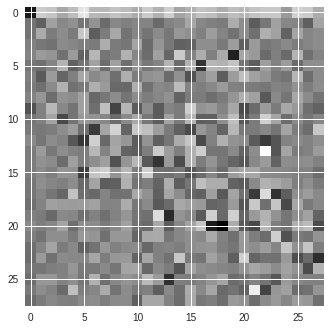

In [251]:
x = trainloader.dataset.train_data[:2].to('cuda')
print(x.shape)
model_harmonic = HarmonicNet(3,18,3,2,1).cuda()#(3,32,4,2,0)
x = model_harmonic.harmonic_block1(x)
print(x.shape)
x = model_harmonic.harmonic_block2(x)
print(x.shape)
x = model_harmonic.harmonic_block3(x)
print(x.shape)
plt.imshow(x[0].cpu().detach().numpy()[0])#model_harmonic.harmonic_block1.filter_bank[1].cpu().numpy()[0])#

In [274]:
model_harmonic = HarmonicNet(3,18,3,2,1)#(3,32,4,2,0)
#model_harmonic

for module in model_harmonic.modules():
  if isinstance(module, nn.Conv2d):
    module.weight.data.normal_(0,0.05)
    module.bias.data.zero_()

#model_harmonic = model_harmonic.to('cuda')
#for parameter in model_harmonic.parameters():
#  parameter.to('cuda')
model_harmonic.cuda()
model_harmonic = torch.nn.DataParallel(model_harmonic, device_ids=range(torch.cuda.device_count()))
base_lr = float(1e-2)
param_dict = dict(model_harmonic.named_parameters())
params = []

loss = nn.CrossEntropyLoss()

optimizer = optim.Adam(model_harmonic.parameters(), lr=base_lr)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc=0

gc.collect()


41

In [0]:
#training_data_ = Loader(path = 'HAM10000_images', color_space='rgb',
#           labels = labels, train=True, 
#           transform=torchvision.transforms.ToTensor())
#gc.collect()
#testing_data_ = Loader(path = 'HAM10000_images',color_space='rgb', 
#           labels = labels, train=False, 
#           transform=torchvision.transforms.ToTensor())
#gc.collect()

In [0]:
%reload_ext autoreload
%autoreload

In [55]:
trainloader = torch.utils.data.DataLoader(training_data_, batch_size=64,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testing_data_, batch_size = 64,
                                         shuffle = True, num_workers = 2)
classes = list(lesion_type_dict.keys())
gc.collect()

7

In [275]:
best_acc = 0
def train(epoch, model, output_step=128):
  model.train()
  for batch_idx, (data, label) in enumerate(trainloader):
    data, label = torch.autograd.Variable(data.cuda()), torch.autograd.Variable(label.cuda())
    optimizer.zero_grad()
    output = model(data)
    loss_ = loss(output, label)
    _, y_pred = torch.max(output, 1)

    
    loss_.backward()
    optimizer.step()
    if batch_idx % output_step == 0:
      print('\nTrain Epoch: {} [{}/{} ({:.0f}%)]\tTraining Loss: {:.6f}\tLR: {}'.format(
             epoch, batch_idx * len(data), len(trainloader.dataset),
             100. * batch_idx / len(trainloader), loss_.data.item(),
             optimizer.param_groups[0]['lr']))
      train_losses.append(loss_.data.item())

def test(epoch, model):
  global best_acc
  model.eval()
  loss_ = 0
  test_loss_ = 0
  correct = 0
  accuracy = 0
  for batch_id, (data, label) in enumerate(testloader):
    data, label = torch.autograd.Variable(data.cuda()), torch.autograd.Variable(label.cuda())
    output = model(data)
    test_loss_ = loss(output, label)
    loss_ += loss(output, label).item()
    pred = output.data.max(1, keepdim=True)[1]
    correct += pred.eq(label.data.view_as(pred)).cpu().sum()
    accuracy = 100. * correct / len(testloader.dataset)
    
  
  if accuracy > best_acc:
        best_acc = accuracy
        save_state(model, best_acc)
  print('Testing: {} [{}/{} ({:.0f}%)]\tTesting Loss: {:.3e}\tLR: {}'.format(
             epoch, batch_id * len(data), len(testloader.dataset),
             100. * batch_id / len(testloader), test_loss_.data.item(),
             optimizer.param_groups[0]['lr']))
  print(f'\nTest set: Average loss: {loss_ * 128./len(testloader.dataset):.3f}, Accuracy: {correct}/{len(testloader.dataset):.3f}\
        ({100. * correct / len(testloader.dataset):.3f}%)')        
  print(f'Best Accuracy: {best_acc:.2f}%\n')
  test_losses.append(test_loss_.data.item())

def adjust_learning_rate(optimizer, epoch):
    update_list = [20, 40, 80, 100, 160] #[120, 200, 240, 280]
    if epoch in update_list:
        for param_group in optimizer.param_groups:
            param_group['lr'] = param_group['lr'] * 0.5
    return

def save_state(model, best_acc):
    print('\n==> Saving model ...')
    state = {
            'best_acc': best_acc,
            'state_dict': model.state_dict(),
            }
    keys = list(state['state_dict'].keys())
    for key in keys:
        if 'module' in key:
            state['state_dict'][key.replace('module.', '')] = \
                    state['state_dict'].pop(key)
    torch.save(state, 'harmonic_network.tar')

gc.collect()

0

In [276]:
train_losses = []
test_losses = []

for epoch in range(200):
  adjust_learning_rate(optimizer, epoch)
  train(epoch, model_harmonic, 64)
  test(epoch, model_harmonic)


Train Epoch: 0 [0/9013 (0%)]	Training Loss: 1.950452	LR: 0.01

Train Epoch: 0 [4096/9013 (45%)]	Training Loss: 1.775601	LR: 0.01

Train Epoch: 0 [8192/9013 (91%)]	Training Loss: 1.580648	LR: 0.01

==> Saving model ...
Testing: 0 [630/1002 (94%)]	Testing Loss: 9.229e-01	LR: 0.01

Test set: Average loss: 1.979, Accuracy: 664/1002.000        (66.000%)
Best Accuracy: 66.00%


Train Epoch: 1 [0/9013 (0%)]	Training Loss: 0.908888	LR: 0.01

Train Epoch: 1 [4096/9013 (45%)]	Training Loss: 0.955292	LR: 0.01

Train Epoch: 1 [8192/9013 (91%)]	Training Loss: 0.916003	LR: 0.01

==> Saving model ...
Testing: 1 [630/1002 (94%)]	Testing Loss: 1.147e+00	LR: 0.01

Test set: Average loss: 1.726, Accuracy: 705/1002.000        (70.000%)
Best Accuracy: 70.00%


Train Epoch: 2 [0/9013 (0%)]	Training Loss: 0.641056	LR: 0.01

Train Epoch: 2 [4096/9013 (45%)]	Training Loss: 0.679200	LR: 0.01

Train Epoch: 2 [8192/9013 (91%)]	Training Loss: 0.929796	LR: 0.01

==> Saving model ...
Testing: 2 [630/1002 (94%)]	Tes

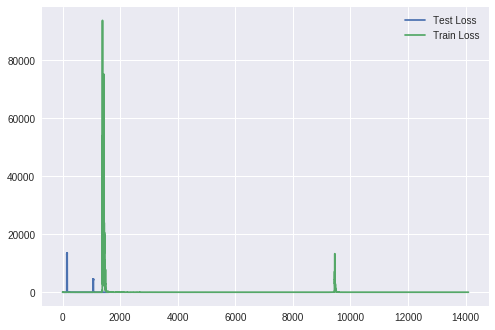

In [273]:
plt.plot(test_losses, label = "Test Loss")
plt.plot(train_losses, label = "Train Loss")
plt.legend()

In [0]:
img =